**Objective of this notebook:**

1) To build input pipeline with image augmentation

2) Various experiments tried out:
   * Include outlier images identified in the EDA
   * Exclude outlier images in the EDA
   * Pre-trained ResNet model without top layers, add new Convblock, 2 FC   
     layer and an output layer to classify 120 classes. 
   * Pre-trained ResNet model without top layers, 

4) To estimate the classification metrics

5) To generate the kaggle submission file

In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
!cp /content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/dog-breed-identification.zip /content/

In [3]:
!unzip dog-breed-identification.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: train/83fad0718581a696132c96c166472627.jpg  
  inflating: train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating: train/840dbad5a691c22611d85b2488bf4cbb.jpg  
  inflating: train/8410ced9ebc1759a7ebce5c42bfb5222.jpg  
  inflating: train/84

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import shutil

import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score,classification_report

import cv2
import tensorflow as tf
from tensorflow.data import AUTOTUNE
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

from tensorflow.keras import layers
from tensorflow.keras.layers import Input,Conv2D,Dense,BatchNormalization,Flatten
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard

from prettytable import PrettyTable

In [28]:
kaggle_file_dir = "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/KaggleSubmission/"

In [5]:
#read csv file having the training image 'file name' and its 'breed category'
train_df = pd.read_csv("/content/labels.csv")

#convert breed to numeric values
unique_breeds = list(pd.unique(train_df["breed"]))
unique_breeds_map = {breed:ind for ind,breed in enumerate(unique_breeds)}
unique_breeds_reversemap = {ind:breed for breed,ind in unique_breeds_map.items()}
train_df["breed_id"] = train_df["breed"].map(unique_breeds_map) 

Get spatial dimensions of the training images

In [6]:
dir="train"
img_names = train_df["id"] + ".jpg"
height = []
width = []

for img in img_names:
  image = cv2.imread(os.path.join(dir,img))
  h,w,c = image.shape
  height.append(h)
  width.append(w)

train_df["height"] = height
train_df["width"] = width
train_df["aspect_ratio"] = train_df["height"] / train_df["width"]  

Remove out-of-proportion images identified in EDA using aspect ratio.

This piece of code will not be run for Experiment #1

In [ ]:
train_df = train_df.loc[(train_df["aspect_ratio"] > 0.5) & (train_df["aspect_ratio"] < 2.3)]
train_df.shape

(10199, 6)

Collect the path, labels of training images

In [7]:
train_dir = "train"
train_image_dir = os.path.join(os.getcwd(),train_dir)+os.sep
paths = train_image_dir + train_df["id"] + ".jpg"
labels = train_df["breed_id"].values
num_classes =  train_df["breed_id"].nunique()

Split the images between training and validation data

In [8]:
val_percent = 0.2
train_percent = 1-val_percent
train_paths,val_paths, train_label,val_label = train_test_split(paths,labels,test_size=val_percent,stratify=labels)
train_size = train_paths.shape[0]
val_size = val_paths.shape[0]

Build input pipeline using the pathnames and labels

In [9]:
resize_height = 350
resize_width  = 350
batch_size = 32

In [10]:
def load_images_test(imagePath,istrain=True):
	# read the image from disk, decode it and resize it
	image = tf.io.read_file(imagePath)
	image = tf.image.decode_jpeg(image, channels=3)
	image = tf.image.resize(image, [resize_height,resize_width])
	return image

In [11]:
def load_images(imagePath,label,istrain=True):
	# read the image from disk, decode it and resize it
	image = tf.io.read_file(imagePath)
	image = tf.image.decode_jpeg(image, channels=3)
	image = tf.image.resize(image, [resize_height,resize_width])
	
	#Convert label into one hot encoding since we need to output probabilities for all classes
	label = tf.one_hot(tf.cast(label, tf.uint8), num_classes)
	return (image, label)

Data Augmentation using Keras Preprocessing Layers

https://www.tensorflow.org/tutorials/images/data_augmentation

In [12]:
def configure_for_performance(ds,istrain=True,istest=False):
  if istrain:
    ds = ds.cache('/content/train_cache')  #since training data is huge, use disk space to cache the data
    ds = ds.shuffle(buffer_size=500)       #reduced buffer size to avoid out of memory errors

  elif istest:
    ds = ds.cache('/content/test_cache')   #use cache on disk
  
  else:
    ds = ds.cache('')         #use RAM memory to cache the validation data as it is relatively very small
    ds = ds.shuffle(buffer_size=100)


  ds = ds.batch(batch_size)
  
  # Use data augmentation only on the training set.
  if istrain:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)
    
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [13]:
#Image Augmentation using Keras Preprocessing layers
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip(mode='horizontal'),
  layers.RandomRotation(0.2,fill_mode='constant'),
  layers.RandomZoom(0.1, 0.1,fill_mode='constant'),
  layers.RandomTranslation(0, 0.2)
])

###Optional Section to see how data augmentation techniques produces images

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_label))
train_ds = train_ds.shuffle(train_size).map(load_images,num_parallel_calls=AUTOTUNE)

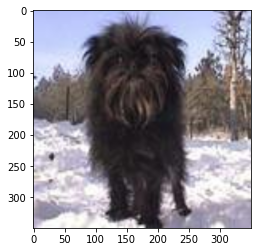

In [ ]:
image, label = next(iter(train_ds))
image = tf.cast(image,tf.float32)/255.0
_ = plt.imshow(image)
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

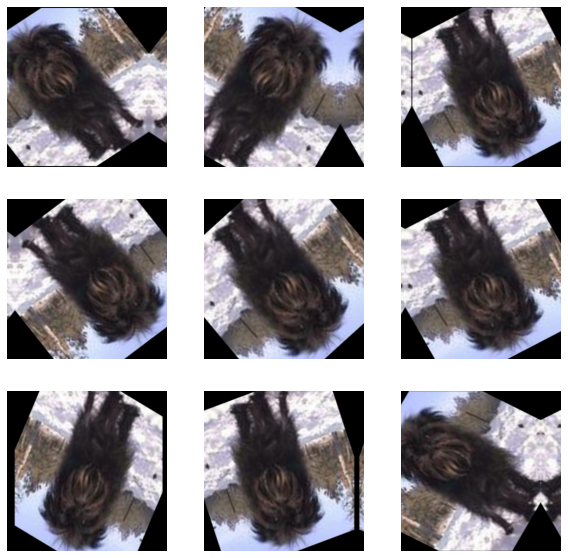

In [ ]:
#Check how the augmentation techniques work
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image,training=True)
  plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")
  

###Continue with Input Pipeline

In [14]:
#shutil.rmtree('train_cache')
os.makedirs("train_cache")

In [15]:
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_label))
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_label))

In [16]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

8177
2045


In [17]:
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_label))
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_label))

train_ds = train_ds.shuffle(train_size).map(load_images,num_parallel_calls=AUTOTUNE)
train_ds = configure_for_performance(train_ds,istrain=True,istest=False)

val_ds = val_ds.shuffle(val_size).map(load_images, num_parallel_calls=AUTOTUNE)
val_ds = configure_for_performance(val_ds,istrain=False,istest=False)

In [18]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

256
64


In [19]:
for image, label in train_ds.take(1): #use 1 batch
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy().shape)

Image shape:  (32, 350, 350, 3)
Label:  (32, 120)


### Get input pipeline for the test directory

In [20]:
#shutil.rmtree("test_cache")
os.makedirs("test_cache")

In [21]:
test_paths = pd.DataFrame(os.listdir("test"),columns=["test_path"])
test_paths_l = [os.path.join("test",path) for path in test_paths["test_path"]]
test_ds = tf.data.Dataset.from_tensor_slices(test_paths_l)
test_ds = test_ds.map(load_images_test,num_parallel_calls=AUTOTUNE)
test_ds = configure_for_performance(test_ds,istrain=False,istest=True)

Process test predictions from model

In [22]:
def process_test_pred(test_pred, csv_name="test_sub.csv"):
  # 1. Identify the class with the maximum probability

  #Convert one-hot vector to integer variable
  test_pred_label = np.argmax(test_pred, axis=1)
  test_pred_label_arr = test_pred_label
  test_paths["pred_breed_id"] = test_pred_label_arr
  #Convert integer variable to categorical variable
  test_paths["pred_breed"] =  test_paths["pred_breed_id"].map(unique_breeds_reversemap)

  # 2. Populate the probabilities for all classes to the dataframe
  out_cols = list(unique_breeds_reversemap.values())
  test_paths[out_cols] = test_pred

  # 3. Process files for kaggle submission format
  test_paths["test_path"] = test_paths["test_path"].str.split('.jpg').str[0]
  out_cols.sort()
  order_cols = ['test_path'] + out_cols
  test_sub = test_paths[order_cols]
  test_sub.rename(columns={"test_path":"id"},inplace=True)
  test_sub.to_csv(csv_name,index=False)

###Experiment#1 
1. Without Removing Outlier Images identified in EDA
2. Using ResNet pretrained model on imagenet data without top layers + Conv2D Layer + MaxPool Layer + Fully Connected layer + Output layer
3. No part of the ResNet model is retrained for this data.

In [23]:
def build_model1():

  tf.keras.backend.clear_session()

  inputs = Input(shape=(resize_height, resize_width, 3))

  #added preprocess_input method as a layer to convert input images to those expected by Resnet
  processed_inputs = preprocess_input(inputs)  

  #use the pretrained ResNet model
  base_model = ResNet50(weights="imagenet", include_top=False)(processed_inputs)

  #Conv Block
  TopConv1 = Conv2D(filters=128,kernel_size=(3,3),strides=(1,1),padding='valid',data_format='channels_last',activation='relu',name='newtopC1')(base_model)
  MaxPool1 = layers.MaxPooling2D((2,2))(TopConv1)

  #Flatten
  flatten = Flatten(data_format='channels_last',name='Flatten')(MaxPool1)

  #FC layer
  FC1 = Dense(units=50,activation='relu',name='FC1')(flatten)

  #output layer
  output = Dense(units=num_classes,activation='softmax',name='Output')(FC1)

  resnet_model = Model(inputs=inputs, outputs=output)
  return resnet_model

In [24]:
#build the model
resnet_model1 = build_model1()

#set the layers of the resnet pretrained model as non-trainable
for layer in resnet_model1.layers[3].layers:   #-7 #-4
  layer.trainable = False

#compile the model

resnet_model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
print(resnet_model1.summary())

94781440/94765736 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 350, 350, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 350, 350, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 350, 350, 3)      0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 newtopC1 (Conv2D)           (None, 9, 9, 128)         2359424   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 128)        0      

In [ ]:
!rm -rfv "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_resnet1"
!mkdir "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_resnet1"

removed '/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_resnet1/resnet1.h5'
removed directory '/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_resnet1'


In [25]:
#Save your model 
checkpoint_dir  = "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_resnet1"
local_ckpt_path = os.path.join(checkpoint_dir, 'resnet1.h5')
checkpoint      = ModelCheckpoint(local_ckpt_path, save_weights_only = True, verbose=1, monitor='val_accuracy',mode='max', save_best_only=True)

In [ ]:
#Callbacks
log_dir = os.path.join("/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/tensorboard",'resnet1', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)
earlystop      = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=4, verbose=1,mode='max')
reduce_lr      = ReduceLROnPlateau(monitor='val_loss', factor=0.5, cooldown=1, patience=2, min_lr=0)
callbacks_list = [reduce_lr,earlystop,checkpoint,tensorboard_callback]

In [ ]:
history = resnet_model1.fit(train_ds,
                    epochs=50,
                    validation_data=val_ds, callbacks=callbacks_list)

Epoch 1/50
256/256 [==============================] - ETA: 0s - loss: 4.7011 - accuracy: 0.0247
Epoch 1: val_accuracy improved from -inf to 0.07237, saving model to /content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_resnet1/resnet1.h5
256/256 [==============================] - 226s 853ms/step - loss: 4.7011 - accuracy: 0.0247 - val_loss: 4.3577 - val_accuracy: 0.0724 - lr: 1.0000e-04
Epoch 2/50
256/256 [==============================] - ETA: 0s - loss: 4.0925 - accuracy: 0.1148
Epoch 2: val_accuracy improved from 0.07237 to 0.22200, saving model to /content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_resnet1/resnet1.h5
256/256 [==============================] - 223s 853ms/step - loss: 4.0925 - accuracy: 0.1148 - val_loss: 3.4228 - val_accuracy: 0.2220 - lr: 1.0000e-04
Epoch 3/50
256/256 [==============================] - ETA: 0s - loss: 3.1480 - accuracy: 0.27

In [ ]:
modelTable = PrettyTable(["Model Name", "Training_Accuracy", "Validation_Accuracy", "Training_Loss","Validation_Loss"])
modelTable.add_row(["ResNet_ConvBlock_FC_Outout with outliers", "88.04%", "76.67%", "0.39", "0.95"])
print(modelTable)

+------------------------------------------+-------------------+---------------------+---------------+-----------------+
|                Model Name                | Training_Accuracy | Validation_Accuracy | Training_Loss | Validation_Loss |
+------------------------------------------+-------------------+---------------------+---------------+-----------------+
| ResNet_ConvBlock_FC_Outout with outliers |       88.04%      |        76.67%       |      0.39     |       0.95      |
+------------------------------------------+-------------------+---------------------+---------------+-----------------+


Process Kaggle File Submission

In [26]:
# use load_weights since only weights are saved during ModelCheckpoint
resnet_model1.load_weights(local_ckpt_path)

In [29]:
test_pred = resnet_model1.predict(test_ds,batch_size=32)
print(test_pred.shape)
process_test_pred(test_pred,csv_name=kaggle_file_dir + "test_sub_ResNet1.csv")

(10357, 120)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


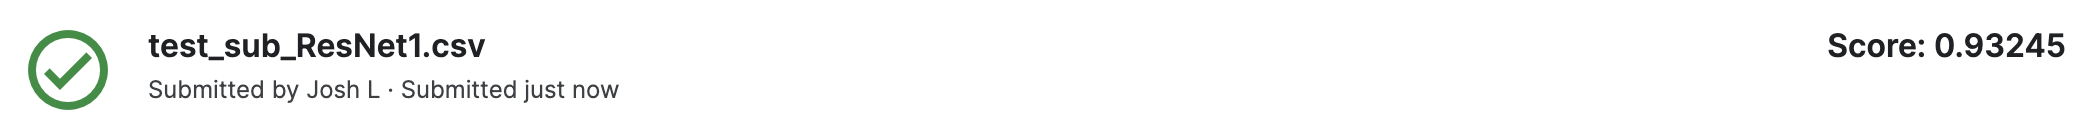

**Conclusion from Experiment#1:**

This is a very basic model without any outlier removals.


###Experiment#2: (Model is same as Experiment#1 but outlier images removed from the train data)
Below code will be run after re-running the input pipeline and removing images with very low and very high aspect ratios.

1. Remove Outlier Images identified in EDA.
2. Using ResNet pretrained model on imagenet data without top layers + Conv2D Layer + MaxPool Layer + Fully Connected layer + Output layer.
3. No part of the ResNet model is retrained for this data.

Model is same as previous experiment..Hence no new model is defined

In [30]:
#build the model
resnet_model2 = build_model1()

#set the layers of the resnet pretrained model as non-trainable
for layer in resnet_model2.layers[3].layers:   
  layer.trainable = False

#compile the model

resnet_model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
print(resnet_model2.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 350, 350, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 350, 350, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 350, 350, 3)      0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 newtopC1 (Conv2D)           (None, 9, 9, 128)         2359424   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 128)        0         
 )                                                           

In [ ]:
!rm -rfv "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_resnet2"
!mkdir "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_resnet2"

removed directory '/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_resnet2'


In [31]:
#Save your model 
checkpoint_dir  = "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_resnet2"
local_ckpt_path = os.path.join(checkpoint_dir, 'resnet1.h5')
checkpoint      = ModelCheckpoint(local_ckpt_path, save_weights_only = True, verbose=1, monitor='val_accuracy',mode='max', save_best_only=True)

In [ ]:
#Callbacks
log_dir = os.path.join("/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/tensorboard",'resnet2', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)
earlystop      = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=4, verbose=1,mode='max')
reduce_lr      = ReduceLROnPlateau(monitor='val_loss', factor=0.5, cooldown=1, patience=2, min_lr=0)
callbacks_list = [reduce_lr,earlystop,checkpoint,tensorboard_callback]

In [ ]:
history = resnet_model2.fit(train_ds,
                    epochs=50,
                    validation_data=val_ds, callbacks=callbacks_list)

Epoch 1/50
255/255 [==============================] - ETA: 0s - loss: 4.6839 - accuracy: 0.0227
Epoch 1: val_accuracy improved from -inf to 0.07745, saving model to /content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_resnet2/resnet1.h5
255/255 [==============================] - 264s 999ms/step - loss: 4.6839 - accuracy: 0.0227 - val_loss: 4.3049 - val_accuracy: 0.0775 - lr: 1.0000e-04
Epoch 2/50
255/255 [==============================] - ETA: 0s - loss: 3.9655 - accuracy: 0.1227
Epoch 2: val_accuracy improved from 0.07745 to 0.25392, saving model to /content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_resnet2/resnet1.h5
255/255 [==============================] - 255s 982ms/step - loss: 3.9655 - accuracy: 0.1227 - val_loss: 3.1351 - val_accuracy: 0.2539 - lr: 1.0000e-04
Epoch 3/50
255/255 [==============================] - ETA: 0s - loss: 3.0388 - accuracy: 0.28

In [ ]:
modelTable = PrettyTable(["Model Name", "Training_Accuracy", "Validation_Accuracy", "Training_Loss","Validation_Loss"])
modelTable.add_row(["ResNet_ConvBlock_FC_Outout with outliers", "88.04%", "76.67%", "0.39", "0.95"])
modelTable.add_row(["ResNet_ConvBlock_FC_Outout without outliers", "92.73%", "92.99%", "0.24", "0.29"])
print(modelTable)

+---------------------------------------------+-------------------+---------------------+---------------+-----------------+
|                  Model Name                 | Training_Accuracy | Validation_Accuracy | Training_Loss | Validation_Loss |
+---------------------------------------------+-------------------+---------------------+---------------+-----------------+
|   ResNet_ConvBlock_FC_Outout with outliers  |       88.04%      |        76.67%       |      0.39     |       0.95      |
| ResNet_ConvBlock_FC_Outout without outliers |       92.73%      |        92.99%       |      0.24     |       0.29      |
+---------------------------------------------+-------------------+---------------------+---------------+-----------------+


Process Kaggle File Submission

In [32]:
# use load_weights since only weights are saved during ModelCheckpoint
resnet_model2.load_weights(local_ckpt_path)

In [33]:
test_pred = resnet_model2.predict(test_ds,batch_size=32)
print(test_pred.shape)
process_test_pred(test_pred,csv_name=kaggle_file_dir + "test_sub_ResNet2.csv")

(10357, 120)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


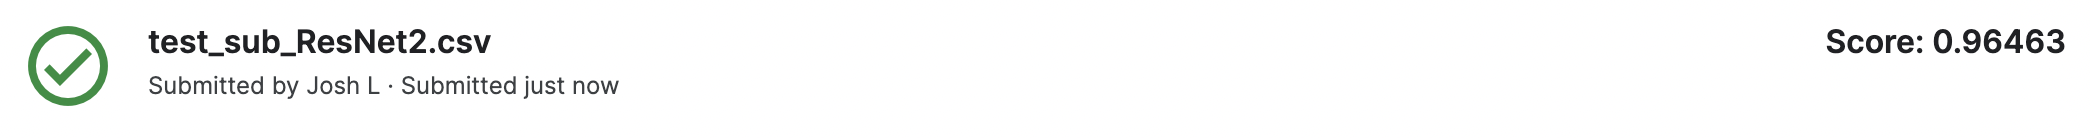

**Conclusions until Experiment#2:**

Removal of heavily distorted images (with low or high aspect ratios) heavily improved the performance of the same model used in Experiment#1.


###Experiment#3:
1. Remove Outlier Images identified in EDA.
2. Using ResNet pretrained model on imagenet data without top layers + Global Average Pooling + Fully Connected layer + Output layer.
3. No part of the Resnet model is retrained.

In [34]:
def build_model3():

  tf.keras.backend.clear_session()

  inputs = Input(shape=(resize_height, resize_width, 3))

  #added preprocess_input method as a layer to convert input images to those expected by Resnet
  processed_inputs = preprocess_input(inputs)  

  #use the pretrained ResNet model (Parameter pooling = 'avg' will take care of the Gobal Average Pooling of the ResNet model features)
  base_model = ResNet50(weights="imagenet", include_top=False,pooling='avg')(processed_inputs) 
  
  #output layer
  output = Dense(units=num_classes,activation='softmax',name='Output')(base_model)

  resnet_model = Model(inputs=inputs, outputs=output)
  return resnet_model

In [35]:
#build the model
resnet_model3 = build_model3()

#set the layers of the resnet pretrained model as non-trainable
for layer in resnet_model3.layers[3].layers:   
  layer.trainable = False

#compile the model

resnet_model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
print(resnet_model3.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 350, 350, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 350, 350, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 350, 350, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 Output (Dense)              (None, 120)               245880    
                                                                 
Total params: 23,833,592
Trainable params: 245,880
Non-trainable params: 23,587,712
___________________________________________

In [ ]:
!rm -rfv "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_resnet3"
!mkdir "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_resnet3"

removed directory '/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_resnet3'


In [36]:
#Save your model 
checkpoint_dir  = "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_resnet3"
local_ckpt_path = os.path.join(checkpoint_dir, 'resnet1.h5')
checkpoint      = ModelCheckpoint(local_ckpt_path, save_weights_only = True, verbose=1, monitor='val_accuracy',mode='max', save_best_only=True)

In [ ]:
#Callbacks
log_dir = os.path.join("/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/tensorboard",'resnet3', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)
earlystop      = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=4, verbose=1,mode='max')
reduce_lr      = ReduceLROnPlateau(monitor='val_loss', factor=0.5, cooldown=1, patience=2, min_lr=0)
callbacks_list = [reduce_lr,earlystop,checkpoint,tensorboard_callback]

In [ ]:
history = resnet_model3.fit(train_ds,
                    epochs=50,
                    validation_data=val_ds, callbacks=callbacks_list)

Epoch 1/50
255/255 [==============================] - ETA: 0s - loss: 4.4344 - accuracy: 0.0800
Epoch 1: val_accuracy improved from -inf to 0.21078, saving model to /content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_resnet3/resnet1.h5
255/255 [==============================] - 272s 1s/step - loss: 4.4344 - accuracy: 0.0800 - val_loss: 3.7522 - val_accuracy: 0.2108 - lr: 1.0000e-04
Epoch 2/50
255/255 [==============================] - ETA: 0s - loss: 3.5200 - accuracy: 0.2929
Epoch 2: val_accuracy improved from 0.21078 to 0.43971, saving model to /content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_resnet3/resnet1.h5
255/255 [==============================] - 288s 1s/step - loss: 3.5200 - accuracy: 0.2929 - val_loss: 2.8898 - val_accuracy: 0.4397 - lr: 1.0000e-04
Epoch 3/50
255/255 [==============================] - ETA: 0s - loss: 2.8822 - accuracy: 0.4469
Epo

In [ ]:
modelTable = PrettyTable(["Model Name", "Training_Accuracy", "Validation_Accuracy", "Training_Loss","Validation_Loss"])
modelTable.add_row(["ResNet_ConvBlock_FC_Outout with outliers", "88.04%", "76.67%", "0.39", "0.95"])
modelTable.add_row(["ResNet_ConvBlock_FC_Outout without outliers", "92.73%", "92.99%", "0.24", "0.29"])
modelTable.add_row(["ResNet_GlobalAvgPooling_Outout without outliers", "92.33%", "92.84%", "0.37", "0.27"])
print(modelTable)

+-------------------------------------------------+-------------------+---------------------+---------------+-----------------+
|                    Model Name                   | Training_Accuracy | Validation_Accuracy | Training_Loss | Validation_Loss |
+-------------------------------------------------+-------------------+---------------------+---------------+-----------------+
|     ResNet_ConvBlock_FC_Outout with outliers    |       88.04%      |        76.67%       |      0.39     |       0.95      |
|   ResNet_ConvBlock_FC_Outout without outliers   |       92.73%      |        92.99%       |      0.24     |       0.29      |
| ResNet_GlobalAvgPooling_Outout without outliers |       92.33%      |        92.84%       |      0.37     |       0.27      |
+-------------------------------------------------+-------------------+---------------------+---------------+-----------------+


Process Kaggle File Submission

In [37]:
# use load_weights since only weights are saved during ModelCheckpoint
resnet_model3.load_weights(local_ckpt_path)

In [38]:
test_pred = resnet_model3.predict(test_ds,batch_size=32)
print(test_pred.shape)
process_test_pred(test_pred,csv_name=kaggle_file_dir + "test_sub_ResNet3.csv")

(10357, 120)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


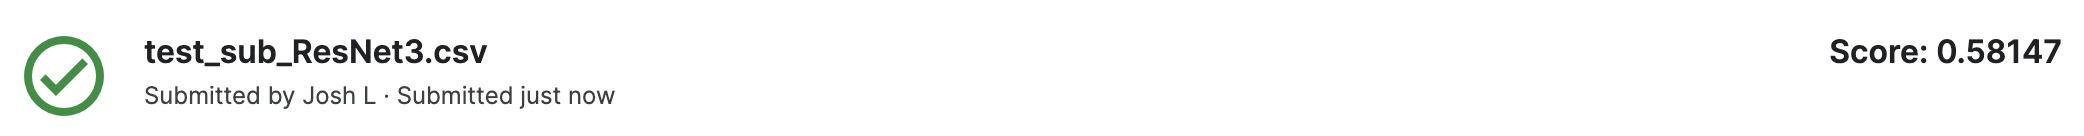

**Conclusions until Experiment#3:**

Removal of heavily distorted images (with low or high aspect ratios) heavily improved the performance of the same model used in Experiment#1.


###Experiment#4: (Same as Experiment#2 but the last 4 layers of ResNet are retrained on the dog breed images)
1. Remove Outlier Images identified in EDA.
2. Using ResNet pretrained model on imagenet data without top layers + Conv2D Layer + MaxPool Layer + Fully Connected layer + Output layer.
3. Retrain the ResNet model for the last 4 layers.

In [39]:
#build the model
resnet_model4 = build_model1()

#set the layers of the resnet pretrained model as non-trainable
for layer in resnet_model2.layers[3].layers[:-4]:   
  layer.trainable = False

#compile the model

resnet_model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
print(resnet_model4.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 350, 350, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 350, 350, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 350, 350, 3)      0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 newtopC1 (Conv2D)           (None, 9, 9, 128)         2359424   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 128)        0         
 )                                                           

In [ ]:
!rm -rfv "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_resnet4"
!mkdir "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_resnet4"

In [40]:
#Save your model 
checkpoint_dir  = "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_resnet4"
local_ckpt_path = os.path.join(checkpoint_dir, 'resnet1.h5')
checkpoint      = ModelCheckpoint(local_ckpt_path, save_weights_only = True, verbose=1, monitor='val_accuracy',mode='max', save_best_only=True)

In [ ]:
#Callbacks
log_dir = os.path.join("/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/tensorboard",'resnet4', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)
earlystop      = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=4, verbose=1,mode='max')
reduce_lr      = ReduceLROnPlateau(monitor='val_loss', factor=0.5, cooldown=1, patience=2, min_lr=0)
callbacks_list = [reduce_lr,earlystop,checkpoint,tensorboard_callback]

In [ ]:
history = resnet_model4.fit(train_ds,
                    epochs=50,
                    validation_data=val_ds, callbacks=callbacks_list)

Epoch 1/50
255/255 [==============================] - ETA: 0s - loss: 4.7747 - accuracy: 0.0151
Epoch 1: val_accuracy improved from -inf to 0.03039, saving model to /content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_resnet4/resnet1.h5
255/255 [==============================] - 279s 1s/step - loss: 4.7747 - accuracy: 0.0151 - val_loss: 4.7523 - val_accuracy: 0.0304 - lr: 1.0000e-04
Epoch 2/50
255/255 [==============================] - ETA: 0s - loss: 4.3344 - accuracy: 0.0773
Epoch 2: val_accuracy improved from 0.03039 to 0.16324, saving model to /content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_resnet4/resnet1.h5
255/255 [==============================] - 267s 1s/step - loss: 4.3344 - accuracy: 0.0773 - val_loss: 3.8083 - val_accuracy: 0.1632 - lr: 1.0000e-04
Epoch 3/50
255/255 [==============================] - ETA: 0s - loss: 3.5335 - accuracy: 0.2054
Epo

In [ ]:
modelTable = PrettyTable(["Model Name", "Retrained","Top Layers Replacement","Outlier Images","Training_Accuracy", "Validation_Accuracy", "Training_Loss","Validation_Loss"])
modelTable.add_row(["ResNet50", "No", "ConvBlock_FC_Outout","Not Removed","88.04%", "76.67%", "0.39", "0.95"])
modelTable.add_row(["ResNet50", "No","ConvBlock_FC_Outout","Removed","92.73%", "92.99%", "0.24", "0.29"])
modelTable.add_row(["ResNet50", "No","GlobalAvgPooling_Outout","Removed","92.33%", "92.84%", "0.37", "0.27"])
modelTable.add_row(["ResNet50", "last 4 layers","ConvBlock_FC_Outout","Removed","98.66%", "91.86%", "0.04", "0.49"])

print(modelTable)

+------------+---------------+-------------------------+----------------+-------------------+---------------------+---------------+-----------------+
| Model Name |   Retrained   |  Top Layers Replacement | Outlier Images | Training_Accuracy | Validation_Accuracy | Training_Loss | Validation_Loss |
+------------+---------------+-------------------------+----------------+-------------------+---------------------+---------------+-----------------+
|  ResNet50  |       No      |   ConvBlock_FC_Outout   |  Not Removed   |       88.04%      |        76.67%       |      0.39     |       0.95      |
|  ResNet50  |       No      |   ConvBlock_FC_Outout   |    Removed     |       92.73%      |        92.99%       |      0.24     |       0.29      |
|  ResNet50  |       No      | GlobalAvgPooling_Outout |    Removed     |       92.33%      |        92.84%       |      0.37     |       0.27      |
|  ResNet50  | last 4 layers |   ConvBlock_FC_Outout   |    Removed     |       98.66%      |       

Process Kaggle File Submission

In [41]:
# use load_weights since only weights are saved during ModelCheckpoint
resnet_model4.load_weights(local_ckpt_path)

In [42]:
test_pred = resnet_model4.predict(test_ds,batch_size=32)
print(test_pred.shape)
process_test_pred(test_pred,csv_name=kaggle_file_dir + "test_sub_ResNet4.csv")

(10357, 120)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


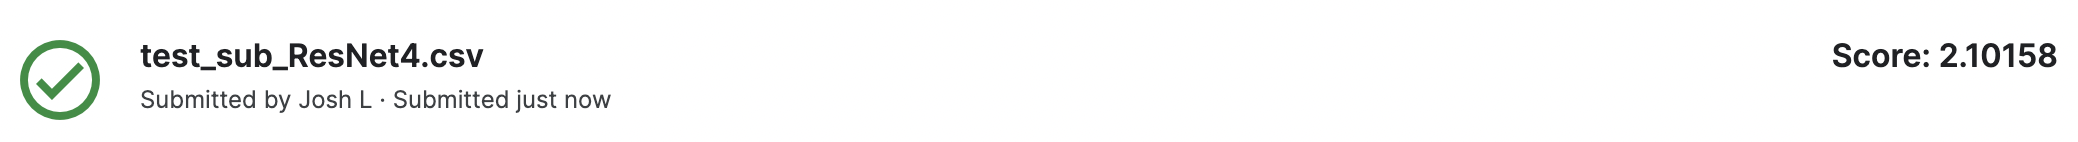

###Experiment#5:(Same as Experiment#3 but the last 4 layers of ResNet are retrained on the dog breed images)
1. Remove Outlier Images identified in EDA.
2. Using ResNet pretrained model on imagenet data without top layers + Global Average Pooling + Fully Connected layer + Output layer.
3. Retrain the ResNet model for the last 7 layers.

In [43]:
#build the model
resnet_model5 = build_model3()

#set the layers of the resnet pretrained model as non-trainable except for its last 4 layers which needs to be re-trained for this data
for layer in resnet_model5.layers[3].layers[:-4]:   
  layer.trainable = False

#compile the model
resnet_model5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
print(resnet_model5.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 350, 350, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 350, 350, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 350, 350, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 Output (Dense)              (None, 120)               245880    
                                                                 
Total params: 23,833,592
Trainable params: 249,976
Non-trainable params: 23,583,616
___________________________________________

In [ ]:
!rm -rfv "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_resnet5"
!mkdir "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_resnet5"

In [44]:
#Save your model 
checkpoint_dir  = "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_resnet5"
local_ckpt_path = os.path.join(checkpoint_dir, 'resnet1.h5')
checkpoint      = ModelCheckpoint(local_ckpt_path, save_weights_only = True, verbose=1, monitor='val_accuracy',mode='max', save_best_only=True)

In [ ]:
#Callbacks
log_dir = os.path.join("/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/tensorboard",'resnet5', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)
earlystop      = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=4, verbose=1,mode='max')
reduce_lr      = ReduceLROnPlateau(monitor='val_loss', factor=0.5, cooldown=1, patience=2, min_lr=0)
callbacks_list = [reduce_lr,earlystop,checkpoint,tensorboard_callback]

In [ ]:
history = resnet_model5.fit(train_ds,
                    epochs=50,
                    validation_data=val_ds, callbacks=callbacks_list)

Epoch 1/50
255/255 [==============================] - ETA: 0s - loss: 4.4783 - accuracy: 0.0673
Epoch 1: val_accuracy improved from -inf to 0.19069, saving model to /content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_resnet5/resnet1.h5
255/255 [==============================] - 244s 920ms/step - loss: 4.4783 - accuracy: 0.0673 - val_loss: 3.7757 - val_accuracy: 0.1907 - lr: 1.0000e-04
Epoch 2/50
255/255 [==============================] - ETA: 0s - loss: 3.5089 - accuracy: 0.2759
Epoch 2: val_accuracy improved from 0.19069 to 0.43725, saving model to /content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment32_DogBreedIdentification/callbacks_resnet5/resnet1.h5
255/255 [==============================] - 239s 920ms/step - loss: 3.5089 - accuracy: 0.2759 - val_loss: 2.8507 - val_accuracy: 0.4373 - lr: 1.0000e-04
Epoch 3/50
255/255 [==============================] - ETA: 0s - loss: 2.8439 - accuracy: 0.44

Process Kaggle File Submission

In [45]:
# use load_weights since only weights are saved during ModelCheckpoint
resnet_model5.load_weights(local_ckpt_path)

In [46]:
test_pred = resnet_model5.predict(test_ds,batch_size=32)
print(test_pred.shape)
process_test_pred(test_pred,csv_name=kaggle_file_dir + "test_sub_ResNet5.csv")

(10357, 120)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


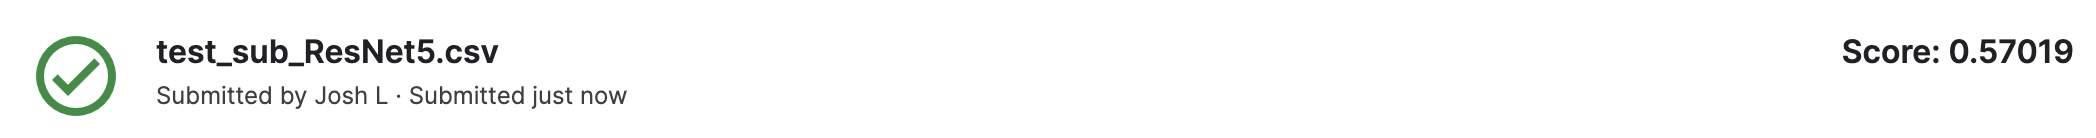

###Print Summary of all experiments performed on ResNet

In [ ]:
modelTable = PrettyTable(["Model Name", "Retrained","Top Layers Replacement","Outlier Images","Training_Accuracy", "Validation_Accuracy", "Training_Loss","Validation_Loss"])
modelTable.add_row(["ResNet50", "No", "ConvBlock_FC_Outout","Not Removed","88.04%", "76.67%", "0.39", "0.95"])
modelTable.add_row(["ResNet50", "No","ConvBlock_FC_Outout","Removed","92.73%", "92.99%", "0.24", "0.29"])
modelTable.add_row(["ResNet50", "No","GlobalAvgPooling_Outout","Removed","92.33%", "92.84%", "0.37", "0.27"])
modelTable.add_row(["ResNet50", "last 4 layers","ConvBlock_FC_Outout","Removed","98.66%", "91.86%", "0.04", "0.49"])
modelTable.add_row(["ResNet50", "last 4 layers","GlobalAvgPooling_Outout","Removed","89.82%", "92.25%", "0.43", "0.299"])

print(modelTable)

+------------+---------------+-------------------------+----------------+-------------------+---------------------+---------------+-----------------+
| Model Name |   Retrained   |  Top Layers Replacement | Outlier Images | Training_Accuracy | Validation_Accuracy | Training_Loss | Validation_Loss |
+------------+---------------+-------------------------+----------------+-------------------+---------------------+---------------+-----------------+
|  ResNet50  |       No      |   ConvBlock_FC_Outout   |  Not Removed   |       88.04%      |        76.67%       |      0.39     |       0.95      |
|  ResNet50  |       No      |   ConvBlock_FC_Outout   |    Removed     |       92.73%      |        92.99%       |      0.24     |       0.29      |
|  ResNet50  |       No      | GlobalAvgPooling_Outout |    Removed     |       92.33%      |        92.84%       |      0.37     |       0.27      |
|  ResNet50  | last 4 layers |   ConvBlock_FC_Outout   |    Removed     |       98.66%      |       

In [47]:
kaggleTable = PrettyTable(["Model Name", "KaggleScore"])
kaggleTable.add_row(["ResNet1",  "0.93245"])
kaggleTable.add_row(["ResNet2",  "0.96463"])
kaggleTable.add_row(["ResNet3",  "0.58147"])
kaggleTable.add_row(["ResNet4",  "2.10158"])
kaggleTable.add_row(["ResNet5",  "0.57019"])
print(kaggleTable)

+------------+-------------+
| Model Name | KaggleScore |
+------------+-------------+
|  ResNet1   |   0.93245   |
|  ResNet2   |   0.96463   |
|  ResNet3   |   0.58147   |
|  ResNet4   |   2.10158   |
|  ResNet5   |   0.57019   |
+------------+-------------+


###Conclusions from the Experiments

1. Removal of outlier images drastically improved the model performance.

2. Pretrained models without retraining are performing equally good as pretrained models with retraining.

In [ ]:
train_out5 = resnet_model5.evaluate(train_ds)
print(train_out5)

255/255 [==============================] - 241s 922ms/step - loss: 0.3969 - accuracy: 0.9042
[0.3969093859195709, 0.9041666388511658]


In [ ]:
train_out4 = resnet_model4.evaluate(train_ds)
print(train_out4)

255/255 [==============================] - 264s 1s/step - loss: 0.0153 - accuracy: 0.9961
[0.015338112600147724, 0.9960784316062927]


In [ ]:
val_out5 = resnet_model5.evaluate(val_ds)
print(val_out5)

64/64 [==============================] - 10s 153ms/step - loss: 0.2941 - accuracy: 0.9201
[0.2941091060638428, 0.920098066329956]


In [ ]:
val_out4 = resnet_model4.evaluate(val_ds)
print(val_out4)

##Predict on train dataset and calculate metrics

In [ ]:
#shutil.rmtree("test_cache")
os.makedirs("test_cache")

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(train_paths)
train_ds = train_ds.map(load_images_test,num_parallel_calls=AUTOTUNE)
train_ds  = configure_for_performance(train_ds, istrain=False, istest=True)
train_pred = resnet_model4.predict(train_ds,batch_size=32)
train_pred.shape

(8159, 120)

In [ ]:
train_pred_df = pd.DataFrame()
train_pred_df["path"] = train_paths 
train_pred_df["path"] = train_pred_df["path"].str.split('/').str[3].str.split('.jpg').str[0]

In [ ]:
shutil.rmtree("test_cache")
os.makedirs("test_cache")
train_ds  = tf.data.Dataset.from_tensor_slices((train_paths,train_label))
train_ds  = train_ds.map(load_images,num_parallel_calls=AUTOTUNE)
train_ds  = configure_for_performance(train_ds, istrain=False, istest=True)
train_out = resnet_model4.evaluate(train_ds)

In [ ]:
# 1. Identify the class with the maximum probability

#Convert one-hot vector to integer variable
train_pred_label = np.argmax(train_pred, axis=1)
train_pred_label_arr = train_pred_label
train_pred_df["pred_breed_id"] = train_pred_label_arr

#Convert integer variable to categorical variable
train_pred_df["pred_breed"] =  train_pred_df["pred_breed_id"].map(unique_breeds_reversemap)


# 2. Populate the probabilities for all classes to the dataframe
out_cols = list(unique_breeds_reversemap.values())
train_pred_df[out_cols] = train_pred

y_pred = train_pred_df["pred_breed_id"].values

###Metrics Calculation

Confusion Matrix

In [ ]:
from keras.utils.np_utils import to_categorical   
train_categorical_true = to_categorical(train_label, num_classes=120)

In [ ]:
train_categorical_true.shape

(8159, 120)

In [ ]:
train_label

array([86, 18, 80, ..., 76, 71, 64])

In [ ]:
y_pred

array([25, 18, 80, ..., 76, 71, 64])

In [ ]:
# Creating  a confusion matrix,which compares the y_test and y_pred
conf_matrix = confusion_matrix(train_label, y_pred)

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
conf_matrix_df = pd.DataFrame(conf_matrix, index = out_cols, columns = out_cols)

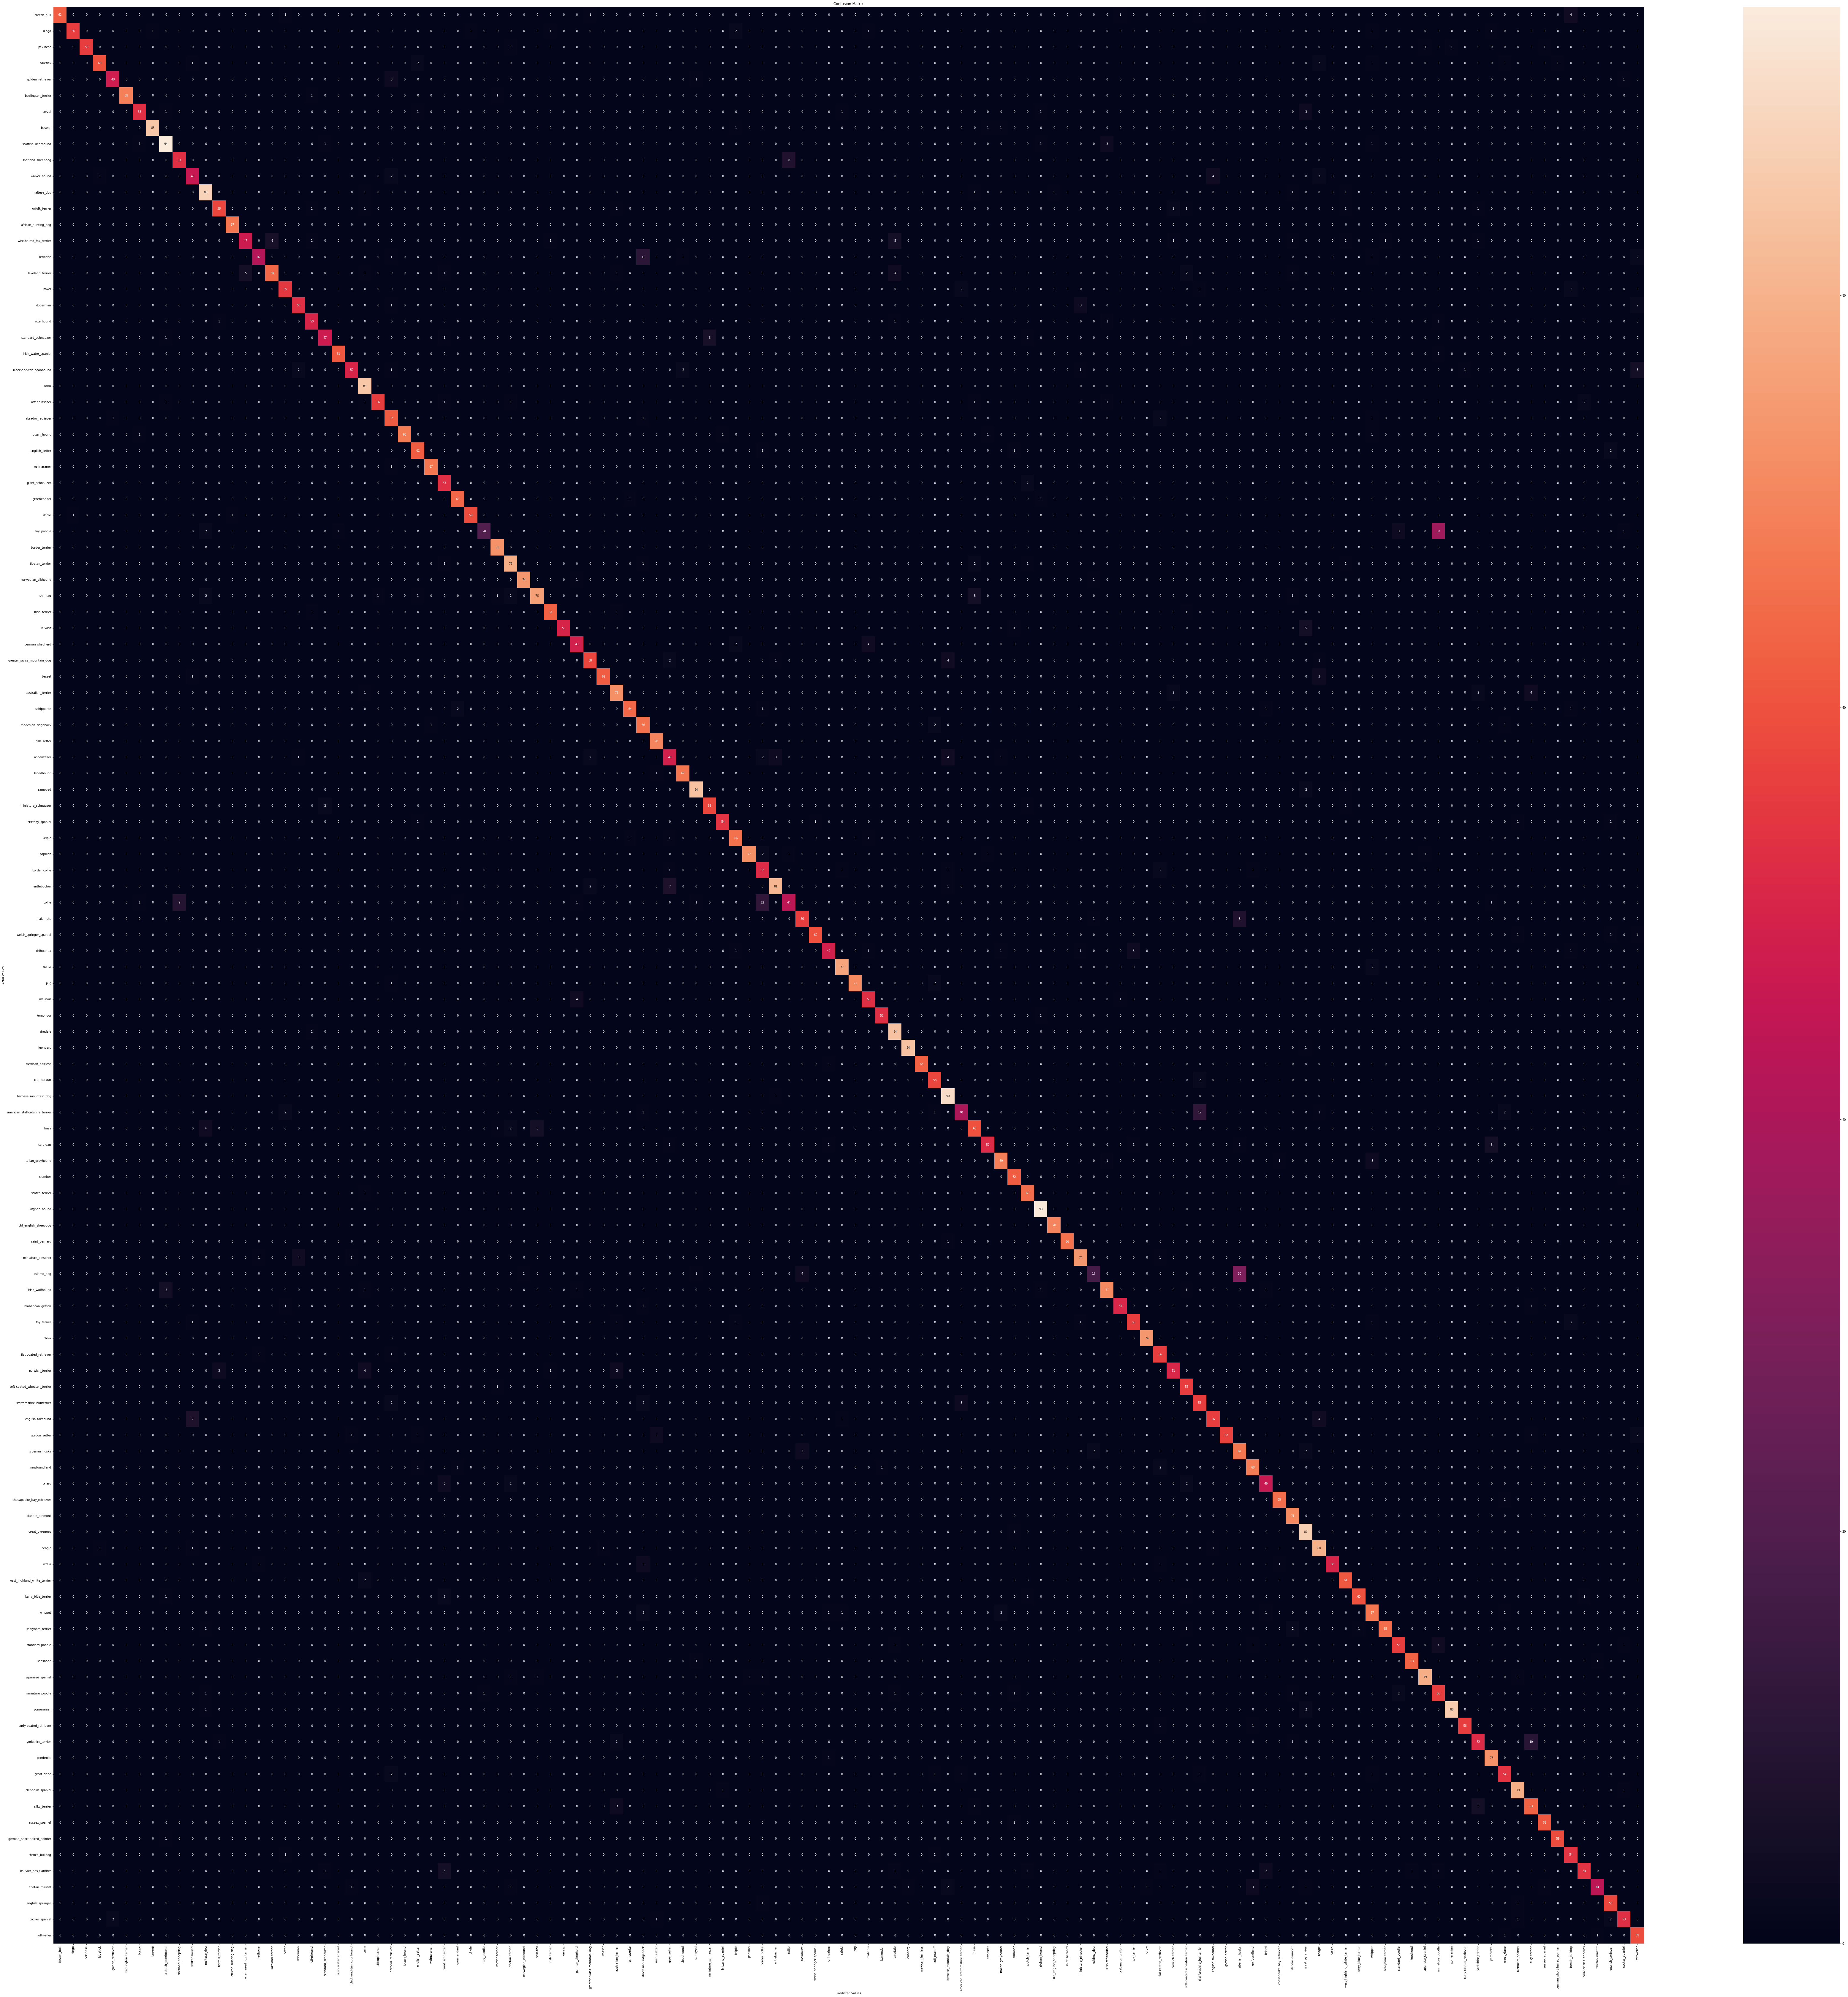

In [ ]:
#Plotting the confusion matrix
plt.figure(figsize=(120,120))
sns.heatmap(conf_matrix_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

Inferences from Confusion Matrix

1. 37 toy_poodle is misclassified as miniature_poodle.

2. 10 yorkshire terrier is misclassified as silky terrier.

3. 30 eskimo_dog is misclassified as siberian_husky.

4. 12 american_staffordshire_terrier is misclassified as staffordshire_bullterrier.

5. 12 collie misclassified as border_collie

6. 9 collie misclassified as scottish_deerhound

7. 11 redbone misclassified as rhodesian_ridgeback



In [ ]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(train_categorical_true, train_pred, multi_class="ovr", average="macro"))

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(train_label, y_pred, target_names=out_cols))

                                precision    recall  f1-score   support

                   boston_bull       1.00      0.89      0.94        70
                         dingo       0.98      0.88      0.93        64
                      pekinese       1.00      0.93      0.97        60
                      bluetick       0.97      0.88      0.92        68
              golden_retriever       0.94      0.91      0.92        53
            bedlington_terrier       1.00      0.97      0.99        71
                        borzoi       0.95      0.88      0.91        60
                       basenji       0.99      0.97      0.98        88
            scottish_deerhound       0.90      0.93      0.92       101
             shetland_sheepdog       0.85      0.87      0.86        61
                  walker_hound       0.81      0.84      0.82        55
                   maltese_dog       0.89      0.95      0.92        93
               norfolk_terrier       0.92      0.88      0.90  

#Generate test file predictions for submission

In [ ]:
shutil.rmtree("test_cache")
os.makedirs("test_cache")

In [ ]:
test_paths = pd.DataFrame(os.listdir("test"),columns=["test_path"])
test_paths_l = [os.path.join("test",path) for path in test_paths["test_path"]]
test_ds = tf.data.Dataset.from_tensor_slices(test_paths_l)
test_ds = test_ds.map(load_images_test,num_parallel_calls=AUTOTUNE)
test_ds = configure_for_performance(test_ds,istrain=False,istest=True)

In [ ]:
len(test_paths)

10357

In [ ]:
steps_per_epoch = np.floor(len(test_paths)/32)

In [ ]:
test_pred = resnet_model4.predict(test_ds,batch_size=32)
test_pred.shape

Process predictions from model

In [ ]:
# 1. Identify the class with the maximum probability

#Convert one-hot vector to integer variable
test_pred_label = np.argmax(test_pred, axis=1)
test_pred_label_arr = test_pred_label
test_paths["pred_breed_id"] = test_pred_label_arr
#Convert integer variable to categorical variable
test_paths["pred_breed"] =  test_paths["pred_breed_id"].map(unique_breeds_reversemap)

# 2. Populate the probabilities for all classes to the dataframe
out_cols = list(unique_breeds_reversemap.values())
test_paths[out_cols] = test_pred

Process files for kaggle submission format

In [ ]:
test_paths["test_path"] = test_paths["test_path"].str.split('.jpg').str[0]
out_cols.sort()
order_cols = ['test_path'] + out_cols
test_sub = test_paths[order_cols]
test_sub.rename(columns={"test_path":"id"},inplace=True)
test_sub.to_csv("test_sub.csv",index=False)

In [ ]:
test_sub.head()

,test_path,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,6619715f0920559fc927310d17d565f9,6.182667e-05,3.053077e-02,2.218138e-05,1.009762e-05,0.005333,1.913905e-04,7.674184e-03,0.000010,0.000010,...,1.808789e-04,1.558250e-03,1.976282e-05,0.000340,0.000116,1.107203e-03,2.370008e-03,0.000303,2.361334e-04,2.312422e-04
1,0d5043156904a8ade08741ce8006fa28,6.623400e-11,8.500026e-07,6.817906e-08,2.414342e-07,0.000134,3.136086e-04,7.647170e-10,0.000026,0.043552,...,4.937892e-10,5.919104e-05,4.038883e-08,0.888465,0.000015,4.935923e-05,2.178950e-09,0.002463,1.059114e-05,6.738331e-09
2,a8b5093fc641e3c13678dad11059498a,4.305539e-07,2.680595e-05,1.557702e-06,6.846075e-06,0.002890,1.072919e-04,5.527844e-06,0.000047,0.012972,...,4.729805e-07,1.232644e-03,1.640272e-05,0.580806,0.000042,4.487392e-02,1.475843e-05,0.001117,3.070199e-03,2.398226e-06
3,012ca7efe684c5cdfb83f35e8fbafe1b,7.760685e-12,1.500191e-11,2.802037e-11,2.037900e-07,0.000113,2.641441e-07,3.237739e-09,0.000002,0.000006,...,3.880746e-09,1.409584e-08,9.575346e-01,0.000022,0.000021,7.304390e-09,1.315708e-11,0.000002,1.661919e-08,1.342924e-09
4,a02d11f19fb899d980fcc387908d1b4e,1.026427e-05,2.956496e-05,3.447208e-06,4.375347e-05,0.000113,1.391682e-02,2.353685e-04,0.148850,0.000394,...,7.795362e-05,4.068003e-03,2.487122e-05,0.000007,0.000004,3.375416e-04,3.104462e-04,0.030775,8.300474e-06,2.953565e-04
